🏗️ Fase 1: Configuración y Mapeo de Variables
Definimos la "Constitución" del Gemelo Digital. Aquí establecemos el mapeo estricto entre la física y el esquema de datos requerido.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import os
import random

# Configuración de estilo
sns.set(style="whitegrid")

class DigitalTwinConfig:
    # Configuración de Tiempo
    START_DATE = "2023-01-01"
    END_DATE = "2025-04-30"
    FREQ = "1h" # Resolución horaria

    # Mapeo de Variables (Física -> Schema Pipeline)
    COLUMN_MAP = {
        'oil_pressure_comp': 'pres_aceite_comp',
        'rpm': 'rpm',
        'engine_oil_pressure': 'presion_aceite_motor',
        'water_pressure': 'presion_agua',
        'crankcase_pressure': 'presion_carter',
        'engine_oil_temp': 'temp_aceite_motor',
        'engine_water_temp': 'temp_agua_motor',
        'manifold_temp_left': 'temp_mult_adm_izq'
    }

    # Parámetros Físicos Base (C-5080)
    NOMINAL_RPM = 1100
    IDLE_RPM = 0
    AMBIENT_TEMP_MEAN = 25
    THERMAL_INERTIA = 0.15  # Factor de retardo térmico (0-1)

config = DigitalTwinConfig()
print("✅ Configuración del Gemelo Digital C-5080 cargada.")

✅ Configuración del Gemelo Digital C-5080 cargada.


🧠 Fase 2 a Fase 7: Motor de Simulación Física (Core Engine)
Este bloque integra la Máquina de Estados, la Física Térmica, la Hidráulica y la Inyección de Fallas en un solo bucle temporal para asegurar consistencia causal (ej: La temperatura no puede subir si las RPM son 0, la presión depende de la temperatura actual).

In [2]:
# ==============================================================================
# 🧠 FASE 2 a 7 MEJORADA: Motor de Física con Degradación (Drift) y Correlación
# ==============================================================================
import pandas as pd
import numpy as np
import random
from datetime import timedelta

def run_simulation(config):
    # Generar índice de tiempo
    date_rng = pd.date_range(start=config.START_DATE, end=config.END_DATE, freq=config.FREQ)
    n_steps = len(date_rng)

    # Inicialización de vectores
    data = {k: np.zeros(n_steps) for k in config.COLUMN_MAP.values()}
    maintenance_log = []

    # Variables de Estado Inicial
    current_temp_oil = 90.0
    current_temp_water = 85.0
    current_rpm = config.NOMINAL_RPM
    state = "STEADY"

    # --- NUEVO CALENDARIO DE FALLAS ROBUSTO ---
    # Garantizamos que haya fallas en el set de entrenamiento (2023-2024)
    # y en el set de prueba (2025) con fechas exactas (horas 00:00:00 para coincidir con el índice)
    faults_schedule = [
        # --- TRAINING SET (Aprender patrones) ---
        {'date': pd.Timestamp('2023-03-15 00:00:00'), 'type': 'Fuga de Refrigerante', 'var': 'temp_agua_motor', 'impact': 35.0, 'drift_days': 10},
        {'date': pd.Timestamp('2023-06-20 00:00:00'), 'type': 'Válvula Admisión Pegada', 'var': 'temp_mult_adm_izq', 'impact': 50.0, 'drift_days': 5},
        {'date': pd.Timestamp('2023-09-10 00:00:00'), 'type': 'Filtro Aceite Obstruido', 'var': 'presion_aceite_motor', 'impact': -30.0, 'drift_days': 7},
        {'date': pd.Timestamp('2023-12-05 00:00:00'), 'type': 'Desgaste Anillos', 'var': 'presion_carter', 'impact': 1.2, 'drift_days': 20},

        # --- REFUERZO (Más ejemplos para el modelo) ---
        {'date': pd.Timestamp('2024-02-15 00:00:00'), 'type': 'Fuga de Refrigerante', 'var': 'temp_agua_motor', 'impact': 35.0, 'drift_days': 8},
        {'date': pd.Timestamp('2024-05-20 00:00:00'), 'type': 'Válvula Admisión Pegada', 'var': 'temp_mult_adm_izq', 'impact': 50.0, 'drift_days': 5},

        # --- TESTING SET (Para evaluar al final) ---
        {'date': pd.Timestamp('2024-10-10 00:00:00'), 'type': 'Filtro Aceite Obstruido', 'var': 'presion_aceite_motor', 'impact': -30.0, 'drift_days': 7},
        {'date': pd.Timestamp('2025-03-01 00:00:00'), 'type': 'Desgaste Anillos', 'var': 'presion_carter', 'impact': 1.2, 'drift_days': 20}
    ]

    print(f"🔄 Iniciando simulación con {len(faults_schedule)} eventos de falla programados...")

    # --- BUCLE PRINCIPAL ---
    for i, timestamp in enumerate(date_rng):

        # 1. Máquina de Estados (Paradas aleatorias muy breves)
        if state == "STEADY" and random.random() < 0.001:
            state = "STOPPED"
            stop_duration = random.randint(2, 6)
            stop_counter = 0

        if state == "STOPPED":
            target_rpm = 0
            stop_counter += 1
            if stop_counter >= stop_duration:
                state = "STEADY"
        else:
            # Variación normal operativa
            target_rpm = config.NOMINAL_RPM + np.random.normal(0, 5)

        # Inercia
        current_rpm = 0.9 * current_rpm + 0.1 * target_rpm

        # 2. Física Base
        ambient_temp = config.AMBIENT_TEMP_MEAN + 5 * np.sin(2 * np.pi * i / 24)
        target_t_oil = 90.0 if current_rpm > 100 else ambient_temp
        target_t_water = 85.0 if current_rpm > 100 else ambient_temp

        current_temp_oil += 0.05 * (target_t_oil - current_temp_oil)
        current_temp_water += 0.05 * (target_t_water - current_temp_water)

        # 3. Inyección de Fallas
        fault_add = {key: 0.0 for key in config.COLUMN_MAP.values()}
        vibration_factor = 1.0 # Ruido base

        for fault in faults_schedule:
            drift_start = fault['date'] - timedelta(days=fault['drift_days'])

            # Ventana de degradación activa
            if drift_start <= timestamp <= fault['date']:
                total_seconds = (fault['date'] - drift_start).total_seconds()
                current_seconds = (timestamp - drift_start).total_seconds()
                progress = current_seconds / total_seconds if total_seconds > 0 else 0

                # Curva de deterioro exponencial (más realista)
                severity = progress ** 2

                # Aplicar impacto a la variable principal
                fault_add[fault['var']] += fault['impact'] * severity

                # Aumentar ruido/vibración conforme se acerca la falla
                vibration_factor += 3.0 * severity

                # Correlaciones físicas (Efecto dominó)
                if fault['var'] == 'temp_agua_motor':
                    # Si sube agua, baja presión aceite (viscosidad)
                    fault_add['presion_aceite_motor'] -= 10.0 * severity

                if fault['var'] == 'presion_aceite_motor':
                    # Si baja presión aceite, sube temp aceite (fricción)
                    fault_add['temp_aceite_motor'] += 15.0 * severity

            # Registrar evento exacto
            if timestamp == fault['date']:
                maintenance_log.append({
                    'Fecha': timestamp,
                    'DESCRIPCION': f"Falla: {fault['type']}",
                    'EQUIPO': 'C-5080'
                })
                # Parada correctiva forzada
                state = "STOPPED"
                stop_duration = 48
                stop_counter = 0

        # 4. Generación de Valores (Aplicando ruido variable)
        # El ruido aumenta cuando hay una falla incipiente (vibration_factor)
        noise = lambda s: np.random.normal(0, s * vibration_factor)

        data['rpm'][i] = max(0, current_rpm + noise(5))

        # Temperaturas
        data['temp_aceite_motor'][i] = current_temp_oil + fault_add['temp_aceite_motor'] + noise(0.5)
        data['temp_agua_motor'][i] = current_temp_water + fault_add['temp_agua_motor'] + noise(0.5)
        data['temp_mult_adm_izq'][i] = (ambient_temp + current_rpm*0.03) + fault_add['temp_mult_adm_izq'] + noise(1.0)

        # Presiones
        visc_factor = 1 + (90 - current_temp_oil) * 0.005 # Viscosidad
        p_oil_base = (current_rpm / 20.0) * visc_factor if current_rpm > 100 else 0

        data['presion_aceite_motor'][i] = max(0, p_oil_base + fault_add['presion_aceite_motor'] + noise(1.0))
        data['pres_aceite_comp'][i] = max(0, (current_rpm / 18.0) + noise(1.0)) if current_rpm > 100 else 0
        data['presion_agua'][i] = (15.0 + noise(0.2)) if current_rpm > 100 else 0
        data['presion_carter'][i] = (current_rpm / 2000.0) + fault_add['presion_carter'] + noise(0.01)

    return data, maintenance_log, date_rng

# Ejecutar y verificar
raw_data, log_list, time_idx = run_simulation(config)
print(f"✅ Simulación completada. Eventos generados: {len(log_list)}")

🔄 Iniciando simulación con 8 eventos de falla programados...
✅ Simulación completada. Eventos generados: 8


🧹 Fase 8: Estructuración del DataFrame Principal

In [3]:
# 1. EJECUTAR LA SIMULACIÓN (Esto es lo que te faltaba)
# Esto llena las variables 'raw_data_dict' y 'time_index' usando la configuración
print("🔄 Ejecutando simulación...")
raw_data_dict, maintenance_log_list, time_index = run_simulation(config)

# 2. Consolidar arrays en DataFrame (Tu código original)
df_main = pd.DataFrame(raw_data_dict)
df_main['hora'] = time_index
df_main.set_index('hora', inplace=True)

# 3. Reordenar columnas según estricto orden solicitado
ordered_cols = [
    'pres_aceite_comp', 'rpm', 'presion_aceite_motor', 'presion_agua',
    'presion_carter', 'temp_aceite_motor', 'temp_agua_motor', 'temp_mult_adm_izq'
]
df_main = df_main[ordered_cols]

print(f"✅ Simulación finalizada y DataFrame Estructurado: {df_main.shape}")

🔄 Ejecutando simulación...
🔄 Iniciando simulación con 8 eventos de falla programados...
✅ Simulación finalizada y DataFrame Estructurado: (20401, 8)


📅 Fase 9: Generación del Archivo de Eventos (Historial)
Generamos el Excel que el notebook de Feature Engineering usará para etiquetar las fallas (target labeling).

In [4]:
# Convertir lista de eventos a DataFrame
df_events = pd.DataFrame(maintenance_log_list)

# Asegurar formato estricto para compatibilidad
if not df_events.empty:
    df_events['Fecha'] = pd.to_datetime(df_events['Fecha'])
    # Ordenar por fecha
    df_events = df_events.sort_values(by='Fecha')

print("✅ DataFrame de Eventos generado con éxito.")
display(df_events) # Display seguro en Colab

✅ DataFrame de Eventos generado con éxito.


,Fecha,DESCRIPCION,EQUIPO
0,2023-03-15,Falla: Fuga de Refrigerante,C-5080
1,2023-06-20,Falla: Válvula Admisión Pegada,C-5080
2,2023-09-10,Falla: Filtro Aceite Obstruido,C-5080
3,2023-12-05,Falla: Desgaste Anillos,C-5080
4,2024-02-15,Falla: Fuga de Refrigerante,C-5080
5,2024-05-20,Falla: Válvula Admisión Pegada,C-5080
6,2024-10-10,Falla: Filtro Aceite Obstruido,C-5080
7,2025-03-01,Falla: Desgaste Anillos,C-5080


🧪 Fase 10, 11 y 12: Validación y Visualización
Validamos tipos de datos y visualizamos la física y las fallas para asegurar realismo antes de guardar.

✅ Validación de Tipos: PASADA


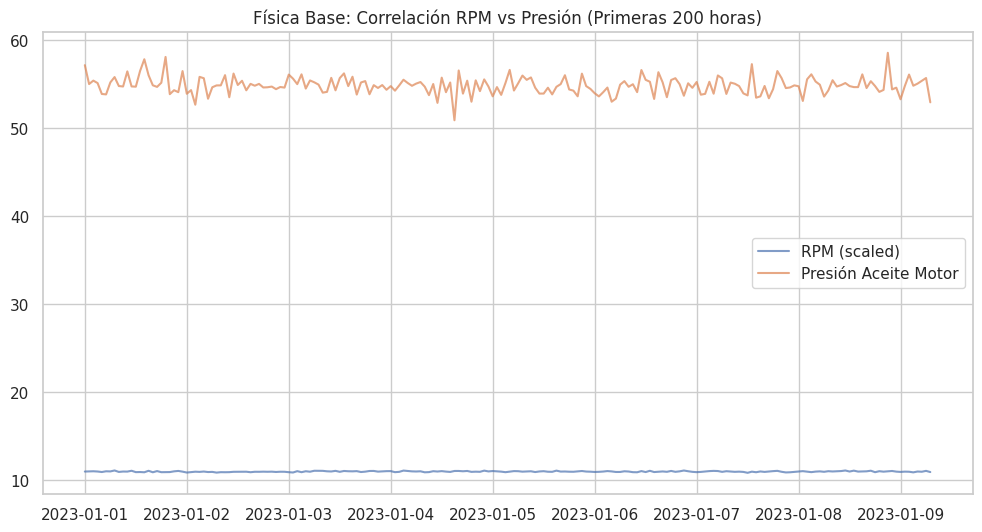

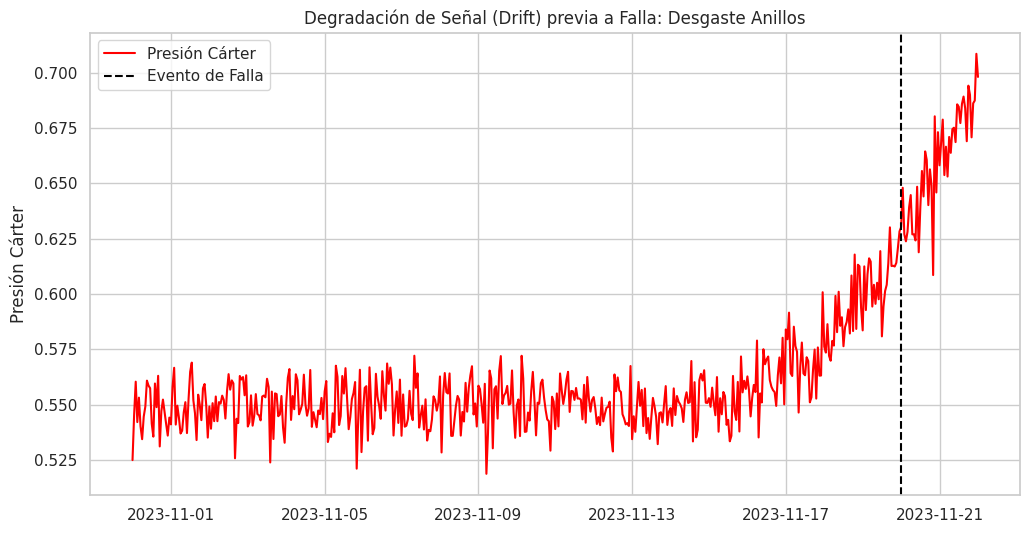

In [5]:
# --- Fase 10: Validación de Tipos ---
assert df_main.index.dtype == 'datetime64[ns]', "Error: El índice debe ser datetime64[ns]"
for col in df_main.columns:
    assert df_main[col].dtype == 'float64', f"Error: La columna {col} no es float64"

print("✅ Validación de Tipos: PASADA")

# --- Fase 11: Visualización Series Temporales (Muestra) ---
plt.figure(figsize=(12, 6))
# Normalizamos para ver correlación visual
plt.plot(df_main.index[:200], df_main['rpm'][:200] / 100, label='RPM (scaled)', alpha=0.7)
plt.plot(df_main.index[:200], df_main['presion_aceite_motor'][:200], label='Presión Aceite Motor', alpha=0.7)
plt.title("Física Base: Correlación RPM vs Presión (Primeras 200 horas)")
plt.legend()
plt.show()

# --- Fase 12: Visualización de un Evento de Falla ---
# Buscamos la fecha de la falla de 'Desgaste Anillos' para graficarla
fault_date = pd.Timestamp('2023-11-20')
window_start = fault_date - timedelta(days=20)
window_end = fault_date + timedelta(days=2)

subset = df_main[(df_main.index >= window_start) & (df_main.index <= window_end)]

plt.figure(figsize=(12, 6))
plt.plot(subset.index, subset['presion_carter'], color='red', label='Presión Cárter')
plt.axvline(x=fault_date, color='black', linestyle='--', label='Evento de Falla')
plt.title(f"Degradación de Señal (Drift) previa a Falla: Desgaste Anillos")
plt.ylabel("Presión Cárter")
plt.legend()
plt.show()

💾 Fase 13 a 17: Persistencia y Verificación Final
Guardamos los archivos en las rutas que espera el siguiente notebook y generamos un reporte final.

In [6]:
# --- Fase 13 & 14: Persistencia ---

# Definir rutas
dir_data = 'data/processed'
dir_events = 'eventos'

os.makedirs(dir_data, exist_ok=True)
os.makedirs(dir_events, exist_ok=True)

# Guardar Parquet (Motor: pyarrow para velocidad y tipos)
parquet_path = os.path.join(dir_data, 'timeseries_data.parquet')
df_main.to_parquet(parquet_path, engine='pyarrow')

# --- CORRECCIÓN DE FORMATO DE FECHAS PARA EXCEL ---
# Convertir la columna de fecha a string ISO (YYYY-MM-DD) para evitar problemas de lectura
df_events_export = df_events.copy()
df_events_export['Fecha'] = df_events_export['Fecha'].dt.strftime('%Y-%m-%d')

# Guardar Excel de Eventos
excel_path = os.path.join(dir_events, 'Historial C1 RGD.xlsx')
df_events_export.to_excel(excel_path, index=False)

# --- Fase 15 & 16: Check de Compatibilidad y Reporte ---

print("-" * 50)
print("🚀 REPORTE DE GENERACIÓN DE GEMELO DIGITAL")
print("-" * 50)

# Verificación de carga
check_df = pd.read_parquet(parquet_path)
check_events = pd.read_excel(excel_path)

print(f"1. Archivo de Señales: {parquet_path}")
print(f"   - Dimensiones: {check_df.shape}")
print(f"   - Columnas: {list(check_df.columns)}")
print(f"   - Rango Fechas: {check_df.index.min()} a {check_df.index.max()}")

print(f"\n2. Archivo de Eventos: {excel_path}")
print(f"   - Total Eventos: {len(check_events)}")
print(f"   - Columnas: {list(check_events.columns)}")
# Mostrar una muestra para verificar formato
print(f"   - Muestra de fechas guardadas: {check_events['Fecha'].head(3).tolist()}")

print("-" * 50)
print("✅ Archivos generados (con fechas corregidas) listos para 03_feature_engineering.ipynb")

--------------------------------------------------
🚀 REPORTE DE GENERACIÓN DE GEMELO DIGITAL
--------------------------------------------------
1. Archivo de Señales: data/processed/timeseries_data.parquet
   - Dimensiones: (20401, 8)
   - Columnas: ['pres_aceite_comp', 'rpm', 'presion_aceite_motor', 'presion_agua', 'presion_carter', 'temp_aceite_motor', 'temp_agua_motor', 'temp_mult_adm_izq']
   - Rango Fechas: 2023-01-01 00:00:00 a 2025-04-30 00:00:00

2. Archivo de Eventos: eventos/Historial C1 RGD.xlsx
   - Total Eventos: 8
   - Columnas: ['Fecha', 'DESCRIPCION', 'EQUIPO']
   - Muestra de fechas guardadas: ['2023-03-15', '2023-06-20', '2023-09-10']
--------------------------------------------------
✅ Archivos generados (con fechas corregidas) listos para 03_feature_engineering.ipynb
